In [8]:
# importing packges

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib3
import re
import html5lib
import numpy as np
import os

In [2]:
def scrappingwebpage(url_text):
    http = urllib3.PoolManager()
    html_page = http.request('GET',url_text)
    soup = BeautifulSoup(html_page.data, 'html5lib')
    gdp_table = soup.find("table", attrs={"class": "wikitable sortable"})
    gdp_table_data = gdp_table.tbody.find_all("tr")  # contains 2 rows

    # Get all the headings of Lists
    headings = []
    for td in gdp_table_data[0].find_all("th"):
        # remove any newlines and extra spaces from left and right
        headings.append(td.text.replace('\n', ' ').strip())
#    print(headings)
    
    table_data = []
    for tr in gdp_table.tbody.find_all("tr"): # find all tr's from table's tbody
        t_row = {}
        # Each table row is stored in the form of
        # t_row = {'Rank': '', 'Country/Territory': '', 'GDP(US$million)': ''}

        # find all td's(3) in tr and zip it with t_header
        for td, th in zip(tr.find_all("td"), headings): 
            t_row[th] = td.text.replace('\n', '').strip()
        table_data.append(t_row)

        # Put the data for the table with his heading.
    df = pd.DataFrame(table_data)
    return df

In [3]:
dataFrame = scrappingwebpage("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
dataFrame.dropna(how='all',inplace=True)
dataFrame.head()

# convert to list
dataFrame['Neighbourhood'] = dataFrame['Neighbourhood'].str.split(',')

# convert list of pd.Series then stack it
dataFrame = (dataFrame
 .set_index(['Postal Code','Borough'])['Neighbourhood']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_2', axis=1)
 .rename(columns={0:'Neighbourhood'}))




In [4]:
#import wget
#wget.download('https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.geojson', 'TorontoCrime.json')
dataFrame.head()
Neighbourhood_df = dataFrame[dataFrame.Neighbourhood != 'Not assigned']
Neighbourhood_df['Neighbourhood']

2                      Parkwoods
3               Victoria Village
4                    Regent Park
5                   Harbourfront
6                 Lawrence Manor
                 ...            
288                    Mimico NW
289           The Queensway West
290               South of Bloor
291     Kingsway Park South West
292        Royal York South West
Name: Neighbourhood, Length: 217, dtype: object

In [5]:
df_crime = pd.read_csv ('..\\Data\\Neighbourhood_Crime_Rates_(Boundary_File)_.csv')
df_crime.shape
df_crime.head()
df_crime.columns

Index(['OBJECTID', 'Neighbourhood', 'Hood_ID', 'Population', 'Assault_2014',
       'Assault_2015', 'Assault_2016', 'Assault_2017', 'Assault_2018',
       'Assault_2019', 'Assault_AVG', 'Assault_CHG', 'Assault_Rate_2019',
       'AutoTheft_2014', 'AutoTheft_2015', 'AutoTheft_2016', 'AutoTheft_2017',
       'AutoTheft_2018', 'AutoTheft_2019', 'AutoTheft_AVG', 'AutoTheft_CHG',
       'AutoTheft_Rate_2019', 'BreakandEnter_2014', 'BreakandEnter_2015',
       'BreakandEnter_2016', 'BreakandEnter_2017', 'BreakandEnter_2018',
       'BreakandEnter_2019', 'BreakandEnter_AVG', 'BreakandEnter_CHG',
       'BreakandEnter_Rate_2019', 'Homicide_2014', 'Homicide_2015',
       'Homicide_2016', 'Homicide_2017', 'Homicide_2018', 'Homicide_2019',
       'Homicide_AVG', 'Homicide_CHG', 'Homicide_Rate_2019', 'Robbery_2014',
       'Robbery_2015', 'Robbery_2016', 'Robbery_2017', 'Robbery_2018',
       'Robbery_2019', 'Robbery_AVG', 'Robbery_CHG', 'Robbery_Rate_2019',
       'TheftOver_2014', 'TheftOver_201

In [6]:
df_crime_summary = df_crime[['Hood_ID','Neighbourhood', 'Population','Assault_AVG', 'AutoTheft_AVG','BreakandEnter_AVG','Homicide_AVG','Robbery_AVG','TheftOver_AVG','Shape__Area', 'Shape__Length']]
df_crime_summary.head()

,Hood_ID,Neighbourhood,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Shape__Area,Shape__Length
0,97,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3,1.161315e+06,5873.270582
1,27,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3,1.324666e+07,18504.777326
2,38,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0,5.346186e+06,11112.109625
3,31,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5,6.038326e+06,10079.426920
4,16,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0,7.946202e+06,11853.189878


In [118]:
df_list = pd.read_csv ('..\\Data\\Neighbourhoods.csv')
df_list.shape
df_list.head()
df_list.columns
df_LIST_summary = df_list[['AREA_LONG_CODE','AREA_NAME', 'LATITUDE','LONGITUDE','Shape__Length']]
df_LIST_summary.head()
dfinal = df_crime_summary.merge(df_LIST_summary, how='inner', left_on='Hood_ID', right_on='AREA_LONG_CODE')
dfinal['Total']= dfinal.iloc[:, 3:9].sum(axis=1)/6
dfinal['Total'] = dfinal['Total']/dfinal['Total'].sum(axis=0)
dfinal.head()



,Hood_ID,Neighbourhood,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Shape__Area,Shape__Length_x,AREA_LONG_CODE,AREA_NAME,LATITUDE,LONGITUDE,Shape__Length_y,Total
0,97,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3,1.161315e+06,5873.270582,97,Yonge-St.Clair (97),43.687859,-79.397871,8130.411276,0.001990
1,27,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3,1.324666e+07,18504.777326,27,York University Heights (27),43.765736,-79.488883,25632.335242,0.019305
2,38,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0,5.346186e+06,11112.109625,38,Lansing-Westgate (38),43.754271,-79.424748,15391.584157,0.004542
3,31,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5,6.038326e+06,10079.426920,31,Yorkdale-Glen Park (31),43.714672,-79.457108,13953.408098,0.009693
4,16,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0,7.946202e+06,11853.189878,16,Stonegate-Queensway (16),43.635518,-79.501128,16379.806316,0.005551


In [119]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [120]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [121]:
# create map of New York using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(dfinal['LATITUDE'], dfinal['LONGITUDE'], dfinal['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [122]:
dfinal.head()

,Hood_ID,Neighbourhood,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Shape__Area,Shape__Length_x,AREA_LONG_CODE,AREA_NAME,LATITUDE,LONGITUDE,Shape__Length_y,Total
0,97,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3,1.161315e+06,5873.270582,97,Yonge-St.Clair (97),43.687859,-79.397871,8130.411276,0.001990
1,27,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3,1.324666e+07,18504.777326,27,York University Heights (27),43.765736,-79.488883,25632.335242,0.019305
2,38,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0,5.346186e+06,11112.109625,38,Lansing-Westgate (38),43.754271,-79.424748,15391.584157,0.004542
3,31,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5,6.038326e+06,10079.426920,31,Yorkdale-Glen Park (31),43.714672,-79.457108,13953.408098,0.009693
4,16,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0,7.946202e+06,11853.189878,16,Stonegate-Queensway (16),43.635518,-79.501128,16379.806316,0.005551


In [123]:
CLIENT_ID = '0VHJ0BNHT50GK3LK24NKBRBWRD3B12ANBF4KTS0BPLM32FJ2' # your Foursquare ID
CLIENT_SECRET = 'VCWFXJVZKF3DF4XTW05UXTXU2P0HJAYS0JAQWDGVQFC3PYJK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0VHJ0BNHT50GK3LK24NKBRBWRD3B12ANBF4KTS0BPLM32FJ2
CLIENT_SECRET:VCWFXJVZKF3DF4XTW05UXTXU2P0HJAYS0JAQWDGVQFC3PYJK


In [124]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
 
        LIMIT = 100    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [125]:
Toronto_venues = getNearbyVenues(names=dfinal['Neighbourhood'],
                                   latitudes=dfinal['LATITUDE'],
                                   longitudes=dfinal['LONGITUDE']
                                  )

Yonge-St.Clair
York University Heights
Lansing-Westgate
Yorkdale-Glen Park
Stonegate-Queensway
Tam O'Shanter-Sullivan
The Beaches
Thistletown-Beaumond Heights
Thorncliffe Park
Danforth East York
Humewood-Cedarvale
Islington-City Centre West
Danforth
Rustic
Scarborough Village
South Parkdale
South Riverdale
St.Andrew-Windfields
Taylor-Massey
Humber Summit
Humbermede
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Cliffcrest
Flemingdon Park
Corso Italia-Davenport
Ionview
Junction Area
Broadview North
Princess-Rosethorn
North Riverdale
Etobicoke West Mall
Forest Hill North
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Trinity-Bellwoods
Victoria Village
Waterfront Communities-The Island
West Hill
West Humber-Clairville
Westminster-Branson
Kennedy Park
Kingsview Village-The Westway
Bayview Woods-Steeles
Clanton Park
Keelesdale-Eglinton West
O'Connor-Parkview
Old East York
Casa Loma
Kensington-Chinatown
Kingsway South
Runnymede-Bloor West Village
Forest Hill South
Henry

In [126]:
Toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Yonge-St.Clair,43.687859,-79.397871,LCBO,43.686991,-79.399238,Liquor Store
1,Yonge-St.Clair,43.687859,-79.397871,The Market By Longo’s,43.686711,-79.399536,Supermarket
2,Yonge-St.Clair,43.687859,-79.397871,The Bagel House,43.687374,-79.393696,Bagel Shop
3,Yonge-St.Clair,43.687859,-79.397871,Daeco Sushi,43.687838,-79.395652,Sushi Restaurant
4,Yonge-St.Clair,43.687859,-79.397871,Union Social Eatery,43.687895,-79.394916,American Restaurant


In [127]:
Toronto_venues.groupby('Neighborhood').count()
Toronto_venuesgrouped =Toronto_venues.groupby('Neighborhood').count()
Toronto_venuesgrouped.head()

#dfinalexpended.head()
dfinalshort = dfinal[['Neighbourhood','Population','Total']] 
#dfinalshort.head()
dfinalexpended = Toronto_venuesgrouped.merge(dfinalshort, how='inner', left_on='Neighborhood', right_on='Neighbourhood')
dfinalexpended.head()
#dfinalplot.drop(['Hood_ID','Assault_AVG','AutoTheft_AVG','BreakandEnter_AVG','Homicide_AVG','Robbery_AVG','TheftOver_AVG','Shape__Area','Shape__Length_x','AREA_LONG_CODE','LATITUDE','LONGITUDE','Shape__Length_y'], axis=1, inplace=True)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Neighbourhood,Population,Total
0,18,18,18,18,18,18,Agincourt North,29113,0.005601
1,19,19,19,19,19,19,Agincourt South-Malvern West,23757,0.007979
2,6,6,6,6,6,6,Alderwood,12054,0.002639
3,24,24,24,24,24,24,Annex,30526,0.014113
4,22,22,22,22,22,22,Banbury-Don Mills,27695,0.005824


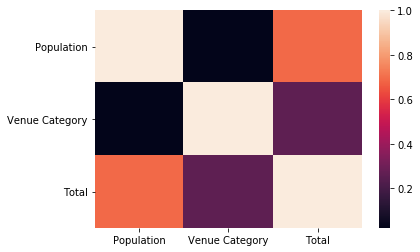

In [128]:
dfinalexpended.head()
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
telpdf = dfinalexpended[['Population','Venue Category','Total']] 
sns.heatmap(telpdf.corr())

In [129]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 279 uniques categories.


In [130]:


# one hot encoding

toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.columns)

Index(['Zoo Exhibit', 'ATM', 'African Restaurant', 'American Restaurant',
       'Amphitheater', 'Animal Shelter', 'Antique Shop', 'Arcade',
       'Argentinian Restaurant', 'Art Gallery',
       ...
       'Video Game Store', 'Video Store', 'Vietnamese Restaurant',
       'Warehouse Store', 'Wine Bar', 'Wine Shop', 'Wings Joint',
       'Women's Store', 'Yoga Studio', 'Zoo'],
      dtype='object', length=279)


In [131]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_onehot_withcrime = toronto_grouped.merge(dfinalshort, how='inner', left_on='Neighborhood', right_on='Neighbourhood')
print(toronto_onehot_withcrime.columns)

Index(['Neighborhood', 'Zoo Exhibit', 'ATM', 'African Restaurant',
       'American Restaurant', 'Amphitheater', 'Animal Shelter', 'Antique Shop',
       'Arcade', 'Argentinian Restaurant',
       ...
       'Warehouse Store', 'Wine Bar', 'Wine Shop', 'Wings Joint',
       'Women's Store', 'Yoga Studio', 'Zoo', 'Neighbourhood', 'Population',
       'Total'],
      dtype='object', length=282)


In [154]:
 %matplotlib qt
sns.heatmap(toronto_onehot_withcrime.corr())
print(toronto_onehot_withcrime.columns)

In [160]:
 %matplotlib qt
print(telpdf.columns)
telpdf = toronto_onehot_withcrime[['ATM','Art Gallery','Amphitheater','Antique Shop','Total']] 
sns.heatmap(telpdf.corr())
print(telpdf.columns)

Index(['ATM', 'Art Gallery', 'Total'], dtype='object')
Index(['ATM', 'Art Gallery', 'Amphitheater', 'Antique Shop', 'Total'], dtype='object')


In [155]:
toronto_onehot_withcrime.describe()


,Zoo Exhibit,ATM,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Population,Total
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,...,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.005288,0.001967,0.001932,0.006233,0.001115,0.000302,0.001110,0.000123,0.000659,0.001364,...,0.006343,0.000345,0.000732,0.001208,0.000453,0.006493,0.001822,0.000949,19504.369565,0.007168
std,0.062119,0.018036,0.017907,0.036346,0.013096,0.003547,0.008327,0.001443,0.007739,0.008189,...,0.025396,0.004054,0.004060,0.011192,0.005320,0.046046,0.007306,0.007976,10102.990154,0.006024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6577.000000,0.001705
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11950.500000,0.003438
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16640.000000,0.005464
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23901.500000,0.008455
max,0.729730,0.200000,0.200000,0.333333,0.153846,0.041667,0.090909,0.016949,0.090909,0.083333,...,0.200000,0.047619,0.031250,0.125000,0.062500,0.500000,0.047619,0.076923,65913.000000,0.037479


In [171]:
 %matplotlib qt
telpdf = toronto_onehot_withcrime[['ATM','Art Gallery','Total']] 
#sns.heatmap(toronto_onehot_withcrime.corrwith(toronto_onehot_withcrime.Total))

import matplotlib.pyplot as plt


corrvect = toronto_onehot_withcrime.corrwith(toronto_onehot_withcrime.Total);
corrdf = pd.DataFrame({'lab':corrvect.index, 'corr':corrvect.values})
 
corrdf.head()
result = corrdf.sort_values(by='corr')
labelslist = result['lab'].values
#plt.matshow(toronto_onehot_withcrime.corrwith(toronto_onehot_withcrime.Total), fignum=f.number)
ax.bar(corrvect[0],corrvect[1])
ax = result.plot.bar()
ax.set_xticklabels(labelslist)

[Text(0, 0, 'Playground'),
 Text(0, 0, 'Toy / Game Store'),
 Text(0, 0, 'Convenience Store'),
 Text(0, 0, 'Bagel Shop'),
 Text(0, 0, 'Cosmetics Shop'),
 Text(0, 0, 'Farmers Market'),
 Text(0, 0, 'Pizza Place'),
 Text(0, 0, 'Gym'),
 Text(0, 0, 'Park'),
 Text(0, 0, 'Latin American Restaurant'),
 Text(0, 0, 'River'),
 Text(0, 0, 'Video Store'),
 Text(0, 0, 'Rental Car Location'),
 Text(0, 0, 'Curling Ice'),
 Text(0, 0, 'Thrift / Vintage Store'),
 Text(0, 0, 'Frozen Yogurt Shop'),
 Text(0, 0, 'Astrologer'),
 Text(0, 0, 'Chiropractor'),
 Text(0, 0, 'Sports Bar'),
 Text(0, 0, 'Trail'),
 Text(0, 0, 'Supermarket'),
 Text(0, 0, 'Beer Store'),
 Text(0, 0, 'Brewery'),
 Text(0, 0, 'Dog Run'),
 Text(0, 0, 'Museum'),
 Text(0, 0, 'Café'),
 Text(0, 0, 'History Museum'),
 Text(0, 0, 'Castle'),
 Text(0, 0, 'Pastry Shop'),
 Text(0, 0, 'Hobby Shop'),
 Text(0, 0, 'IT Services'),
 Text(0, 0, 'Asian Restaurant'),
 Text(0, 0, 'Garden'),
 Text(0, 0, 'Hockey Arena'),
 Text(0, 0, 'Non-Profit'),
 Text(0, 0, 'Ling

In [135]:
corrdf.head()

,lab,corr
0,Zoo Exhibit,0.038756
1,ATM,0.052415
2,African Restaurant,-0.037568
3,American Restaurant,-0.051605
4,Amphitheater,-0.017105


In [136]:
toronto_onehot_withcrime.shape

(138, 282)

In [137]:
num_top_venues = 5
toronto_onehot_withcrimeDrop =toronto_grouped[:]
print(toronto_grouped.columns)
print(toronto_onehot_withcrime.columns)
#toronto_onehot_withcrimeDrop.drop(['Neighbourhood'], axis=1, inplace=True)

for hood in toronto_onehot_withcrimeDrop['Neighborhood']:
#    print("----"+hood+"----")
    temp = toronto_onehot_withcrimeDrop[toronto_onehot_withcrimeDrop['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')

Index(['Neighborhood', 'Zoo Exhibit', 'ATM', 'African Restaurant',
       'American Restaurant', 'Amphitheater', 'Animal Shelter', 'Antique Shop',
       'Arcade', 'Argentinian Restaurant',
       ...
       'Video Game Store', 'Video Store', 'Vietnamese Restaurant',
       'Warehouse Store', 'Wine Bar', 'Wine Shop', 'Wings Joint',
       'Women's Store', 'Yoga Studio', 'Zoo'],
      dtype='object', length=279)
Index(['Neighborhood', 'Zoo Exhibit', 'ATM', 'African Restaurant',
       'American Restaurant', 'Amphitheater', 'Animal Shelter', 'Antique Shop',
       'Arcade', 'Argentinian Restaurant',
       ...
       'Warehouse Store', 'Wine Bar', 'Wine Shop', 'Wings Joint',
       'Women's Store', 'Yoga Studio', 'Zoo', 'Neighbourhood', 'Population',
       'Total'],
      dtype='object', length=282)


In [138]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [174]:
num_top_venues = 10
toronto_onehot_withcrimeDrop =toronto_onehot_withcrime[:]
print(toronto_onehot_withcrimeDrop.columns)
toronto_onehot_withcrimeDrop.drop(['Neighbourhood'], axis=1, inplace=True)
print(toronto_onehot_withcrimeDrop.columns)
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_onehot_withcrimeDrop['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_onehot_withcrimeDrop.iloc[ind, :], num_top_venues)
print(neighborhoods_venues_sorted.columns)
neighborhoods_venues_sortedwithdrop = neighborhoods_venues_sorted[:]
# neighborhoods_venues_sortedwithdrop.drop(['1st Most Common Venue','2nd Most Common Venue'], axis=1, inplace=True)
neighborhoods_venues_sortedwithdrop.head()

Index(['Neighborhood', 'Zoo Exhibit', 'ATM', 'African Restaurant',
       'American Restaurant', 'Amphitheater', 'Animal Shelter', 'Antique Shop',
       'Arcade', 'Argentinian Restaurant',
       ...
       'Warehouse Store', 'Wine Bar', 'Wine Shop', 'Wings Joint',
       'Women's Store', 'Yoga Studio', 'Zoo', 'Neighbourhood', 'Population',
       'Total'],
      dtype='object', length=282)
Index(['Neighborhood', 'Zoo Exhibit', 'ATM', 'African Restaurant',
       'American Restaurant', 'Amphitheater', 'Animal Shelter', 'Antique Shop',
       'Arcade', 'Argentinian Restaurant',
       ...
       'Vietnamese Restaurant', 'Warehouse Store', 'Wine Bar', 'Wine Shop',
       'Wings Joint', 'Women's Store', 'Yoga Studio', 'Zoo', 'Population',
       'Total'],
      dtype='object', length=281)


C:\Users\souhe\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['Neighborhood', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Population,Chinese Restaurant,Bakery,Clothing Store,Pizza Place,Liquor Store,Fried Chicken Joint,Frozen Yogurt Shop,Beer Store,Sandwich Place
1,Agincourt South-Malvern West,Population,Chinese Restaurant,Mediterranean Restaurant,Asian Restaurant,Pool Hall,Restaurant,Noodle House,Cantonese Restaurant,Café,Seafood Restaurant
2,Alderwood,Population,Pizza Place,Coffee Shop,Dance Studio,Pharmacy,Convenience Store,Total,Antique Shop,Donut Shop,Fish & Chips Shop
3,Annex,Population,Café,Sandwich Place,Pub,Coffee Shop,Burger Joint,Donut Shop,French Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant
4,Banbury-Don Mills,Population,Coffee Shop,Gourmet Shop,Shoe Store,Pizza Place,Health & Beauty Service,Bubble Tea Shop,Shopping Mall,Sandwich Place,Cantonese Restaurant


In [175]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_onehot_withcrime.drop(['Neighborhood','Neighbourhood','Population'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 3, 0, 7, 3, 0])

In [176]:
# add clustering labels
print(neighborhoods_venues_sorted.columns)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dfinal


Index(['Neighborhood', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')


In [177]:
dfinal

,Hood_ID,Neighbourhood,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Shape__Area,Shape__Length_x,AREA_LONG_CODE,AREA_NAME,LATITUDE,LONGITUDE,Shape__Length_y,Total
0,97,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3,1.161315e+06,5873.270582,97,Yonge-St.Clair (97),43.687859,-79.397871,8130.411276,0.001990
1,27,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3,1.324666e+07,18504.777326,27,York University Heights (27),43.765736,-79.488883,25632.335242,0.019305
2,38,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0,5.346186e+06,11112.109625,38,Lansing-Westgate (38),43.754271,-79.424748,15391.584157,0.004542
3,31,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5,6.038326e+06,10079.426920,31,Yorkdale-Glen Park (31),43.714672,-79.457108,13953.408098,0.009693
4,16,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0,7.946202e+06,11853.189878,16,Stonegate-Queensway (16),43.635518,-79.501128,16379.806316,0.005551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,130,Milliken,26572,83.8,58.5,108.3,0.2,32.7,16.5,9.477859e+06,16781.477343,130,Milliken (130),43.820691,-79.275009,23261.716888,0.008701
136,46,Pleasant View,15818,46.0,13.5,19.8,0.2,11.8,3.8,2.967493e+06,7944.829848,46,Pleasant View (46),43.786982,-79.334948,11016.711770,0.002758
137,94,Wychwood,14349,70.2,13.2,34.0,0.3,13.8,2.3,1.682111e+06,5435.021879,94,Wychwood (94),43.676919,-79.425515,7515.779658,0.003881
138,56,Leaside-Bennington,16828,32.8,18.2,33.3,0.2,7.5,5.2,4.784766e+06,14836.618578,56,Leaside-Bennington (56),43.703797,-79.366072,20531.730658,0.002819


In [178]:
dfinalShrinked = dfinal[['Neighbourhood','LATITUDE','LONGITUDE']] 

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dfinalShrinked = dfinalShrinked.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Hood_ID,Neighbourhood,Population,Assault_AVG,AutoTheft_AVG,BreakandEnter_AVG,Homicide_AVG,Robbery_AVG,TheftOver_AVG,Shape__Area,Shape__Length_x,AREA_LONG_CODE,AREA_NAME,LATITUDE,LONGITUDE,Shape__Length_y,Total
0,97,Yonge-St.Clair,12528,31.0,4.3,23.3,0.0,5.7,4.3,1.161315e+06,5873.270582,97,Yonge-St.Clair (97),43.687859,-79.397871,8130.411276,0.001990
1,27,York University Heights,27593,333.2,106.3,113.2,0.8,75.8,36.3,1.324666e+07,18504.777326,27,York University Heights (27),43.765736,-79.488883,25632.335242,0.019305
2,38,Lansing-Westgate,16164,70.7,23.7,38.8,1.7,14.7,7.0,5.346186e+06,11112.109625,38,Lansing-Westgate (38),43.754271,-79.424748,15391.584157,0.004542
3,31,Yorkdale-Glen Park,14804,160.2,55.5,63.3,1.2,31.5,22.5,6.038326e+06,10079.426920,31,Yorkdale-Glen Park (31),43.714672,-79.457108,13953.408098,0.009693
4,16,Stonegate-Queensway,25051,83.2,28.7,52.8,0.0,20.7,6.0,7.946202e+06,11853.189878,16,Stonegate-Queensway (16),43.635518,-79.501128,16379.806316,0.005551


In [179]:
dfinalShrinked.head() 

,Neighbourhood,LATITUDE,LONGITUDE,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Yonge-St.Clair,43.687859,-79.397871,0.0,Population,Coffee Shop,Italian Restaurant,Sushi Restaurant,Pizza Place,Thai Restaurant,Pub,Bank,Café,Pharmacy
1,York University Heights,43.765736,-79.488883,0.0,Population,Massage Studio,Japanese Restaurant,Pizza Place,Coffee Shop,Caribbean Restaurant,Fast Food Restaurant,Metro Station,Sushi Restaurant,Furniture / Home Store
2,Lansing-Westgate,43.754271,-79.424748,5.0,Population,Park,Total,African Restaurant,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School
3,Yorkdale-Glen Park,43.714672,-79.457108,0.0,Population,Fast Food Restaurant,Restaurant,Greek Restaurant,Bowling Alley,Seafood Restaurant,Café,Bookstore,Fried Chicken Joint,Sandwich Place
4,Stonegate-Queensway,43.635518,-79.501128,8.0,Population,Baseball Field,Business Service,Total,History Museum,Dog Run,Field,Fast Food Restaurant,Farmers Market,Farm


In [180]:

dfinalShrinked['Cluster Labels'].replace('', np.nan, inplace=True)
dfinalShrinked.dropna(subset=['Cluster Labels'], inplace=True)
dfinalShrinked['Cluster Labels'] = dfinalShrinked['Cluster Labels'].astype('int32')
dfinalShrinked.to_csv('file_name.csv')
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfinalShrinked['LATITUDE'], dfinalShrinked['LONGITUDE'], dfinalShrinked['Neighbourhood'], dfinalShrinked['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [181]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 0, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,43.687859,Coffee Shop,Italian Restaurant,Sushi Restaurant,Pizza Place,Thai Restaurant,Pub,Bank,Café,Pharmacy
1,43.765736,Massage Studio,Japanese Restaurant,Pizza Place,Coffee Shop,Caribbean Restaurant,Fast Food Restaurant,Metro Station,Sushi Restaurant,Furniture / Home Store
3,43.714672,Fast Food Restaurant,Restaurant,Greek Restaurant,Bowling Alley,Seafood Restaurant,Café,Bookstore,Fried Chicken Joint,Sandwich Place
6,43.671050,Japanese Restaurant,Coffee Shop,Park,Pub,Bar,Thai Restaurant,Bakery,BBQ Joint,Pizza Place
7,43.737988,Indian Restaurant,Caribbean Restaurant,Pizza Place,ATM,Pharmacy,Coffee Shop,Supermarket,Thai Restaurant,Bank
...,...,...,...,...,...,...,...,...,...,...
133,43.676773,Bar,Baseball Field,Grocery Store,Café,Total,Ethiopian Restaurant,Egyptian Restaurant,Electronics Store,Elementary School
134,43.791536,Bridal Shop,Café,Total,History Museum,Dog Run,Field,Fast Food Restaurant,Farmers Market,Farm
136,43.786982,Breakfast Spot,Japanese Restaurant,Convenience Store,Pharmacy,Park,Restaurant,Shopping Mall,Skating Rink,Burger Joint
138,43.703797,Coffee Shop,Brewery,Shopping Mall,Bike Shop,Fish & Chips Shop,Sporting Goods Shop,Burger Joint,Skating Rink,Mexican Restaurant


In [182]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 2, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,43.666051,Playground,Construction & Landscaping,Total,American Restaurant,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School
54,43.694526,Playground,Total,African Restaurant,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School


In [183]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 3, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,43.694998,Theater,Park,Total,American Restaurant,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
31,43.671995,Café,Park,Dog Run,Pool,Total,Animal Shelter,Donut Shop,Fish & Chips Shop,Filipino Restaurant
40,43.767490,Park,Construction & Landscaping,Gym / Fitness Center,Total,Amphitheater,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
42,43.778813,American Restaurant,Gym / Fitness Center,Park,Total,Amphitheater,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
45,43.796802,Basketball Court,Dog Run,Park,Total,Amphitheater,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
50,43.681852,Park,History Museum,Bistro,Historic Site,Modern European Restaurant,Museum,Castle,Steakhouse,Total
57,43.688569,Women's Store,Park,Total,African Restaurant,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
61,43.802988,Residential Building (Apartment / Condo),Park,Total,American Restaurant,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
64,43.670886,Park,Indian Restaurant,Fast Food Restaurant,Total,Amphitheater,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store
71,43.790775,Home Service,Park,Bus Station,Construction & Landscaping,Total,Wine Shop,Elementary School,Dog Run,Donut Shop


In [186]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 4, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,43.63388,Boat or Ferry,Total,Hobby Shop,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store


In [187]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 5, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,43.754271,Park,Total,African Restaurant,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School
46,43.741978,Park,Home Service,Total,Women's Store,Elementary School,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
120,43.701326,Park,Total,African Restaurant,Event Space,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School


In [188]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 6, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,43.75892,Auto Garage,Total,Hobby Shop,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store


In [189]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 7, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,43.711609,Construction & Landscaping,Total,Fish & Chips Shop,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Farm,Donut Shop
113,43.776361,Trail,Construction & Landscaping,Total,American Restaurant,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School


In [190]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 8, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,43.635518,Baseball Field,Business Service,Total,History Museum,Dog Run,Field,Fast Food Restaurant,Farmers Market,Farm
16,43.649292,Business Service,Government Building,Lake,Garden Center,Total,Animal Shelter,Eastern European Restaurant,Flea Market,Fish Market


In [191]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 9, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,43.782376,Park,Moving Target,Total,American Restaurant,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School
34,43.745636,Park,Pool,Tea Room,Moving Target,Total,Animal Shelter,African Restaurant,Dumpling Restaurant,Eastern European Restaurant
91,43.733292,Business Service,Moving Target,Park,Total,Amphitheater,Falafel Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store


In [192]:
dfinalShrinked.loc[dfinalShrinked['Cluster Labels'] == 10, dfinalShrinked.columns[[1] + list(range(5, dfinalShrinked.shape[1]))]]

,LATITUDE,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
